In [1]:
import random
from collections import defaultdict

In [2]:
%%writefile submission.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col, translate


Writing submission.py


# Overview

In (regular) Q-learning, the agent learns the *value* of taking a particular action in a particular state. Specifically, for each possible state and action, the agent learns the **expected total reward the agent would get if it took that action** (and then acted perferctly optimally afterwards). This expected total reward for a given (state, action) pair called its **Q-Value**. If the Q-value of each (state, action) pair is known, the agent can compare all the possible actions it can take from a state, and pick the one with the biggest Q-value. This works well when there's a manageable number of states, but it doesn't scale well to large (or even medium-sized) state spaces, since the algorithm has to track and learn about each (state, action) pair separately.

For Hungry Geese, we can be pretty sure that there are over $2^{77}$ states: if we only consider the possibility of each cell on the board being either occupied by a snake or not occupied, there are $2^{77}$ possible combnations. Some of those combinations might be impossible to achieve during a game with 4 snakes, but on the other hand, we haven't even started considering the locations of food *or* how those occupied spaces are connected - which snakes are occupying which spaces, where the heads are, etc. We can't keep that many states in memory, let alone learn about all of them, so we need a simplified approach.

Approximate Q-learning seeks to, well, approximate the Q-value of all possible states (or at least all important ones) with a function. The input to the function is the description of a state and an action, and the output is the Q value; in other words, the function tries to approximate the answer to the question: "**If I took this action right now, what would be the best score/reward/place I could achieve after this point in the game?**" (this formulation can be useful when trying to decide what exactly to calculate in your function).

One simple(ish) approach to approximate Q-learning - the one I'm using in this notebook -  is to approximate the Q values through a **linear combination of important features of the space**:
$$Q = \sum_i{w_i F_i(s, a)}$$

The features are manually designed calculations which capture important things about the state our goose finds itself in. The "learning" part, then, is finding a set of weights such that the resulting Q actually approximates the real Q-value - the reward we should expect to get after taking this action.

I like this kind of approach in part because of how *declarative* it is: I get to focus on describing several independent but important aspects of a game state - in essense, encoding the rules of the game and the important considerations that the agent should pay attention to. And the agent's actual behavior (ideally) emerges directly from what it learns about how these considerations affect the outcome.

# Helper functions

These are mostly one-liners for getting info out of the observation data structure, to help keep subsequent code readable and less error-prone.

In [3]:
%%writefile -a submission.py

def my_snake(obs):
    return obs.geese[obs.index]

Appending to submission.py


In [4]:
%%writefile -a submission.py

def my_head(obs):
    return my_snake(obs)[0]

Appending to submission.py


In [5]:
%%writefile -a submission.py

def translate_my_head(config, obs, action):
    return translate(position=my_head(obs), direction=action, columns=config.columns, rows=config.rows)

Appending to submission.py


In [6]:
%%writefile -a submission.py

def step(obs):
    # obs.step starts counting at 0; "step number" (for the purpose of hunger and episodeSteps) seems to start counting at 1.
    return obs.step+1 

Appending to submission.py


In [7]:
%%writefile -a submission.py

def action_eats_food(config, obs, action):
    return (translate_my_head(config, obs, action) in obs.food)

Appending to submission.py


# State tracking globals

These are necessary to track important game state which is not provided as part of the Observation object. They are (somewhat naively) updated every time that the agent function is called.

In [8]:
%%writefile -a submission.py

prev_action = None

Appending to submission.py


# Q-functions

These are the $F_i$ in the approximate Q-value calculation. Each one should capture some important aspect of the state, and of taking the given action in the given state.

As I mentioned in the introduction, together, these functions should be able to give an approximate answer to the question "**How will my future reward be affected by this action?**", and this affected my choice of the particular functions I used. 

For example, I went with a delta_length function (how will my length change if I do this?) rather than total length, since I wanted to capture the idea that adding one to my length would increase my final score by 1. And  I tried to make up a "time-to-live"(ttl) style function for capturing the effect of hunger, since the effect of colliding with things or not eating is that my final score may be smaller if I die early.

If I chose to use total length or "time before starvation" functions, this would not actually affect the *behavior* of an agent with the same weights - but it *would* make training the weights more volatile, since the training step is trying to find an approximation which fits the actual Q-value.


Altogether, I'm currently using  7 Q-functions, though two of them (`is_first_step` and `one`) are entirely for the training part, and don't actually affect the decision-making at all. (there are also a couple of alternative functions I ended up not using - they are folded away in the notebook.)

In [9]:
%%writefile -a submission.py

# Will my length change due to this action?
def delta_length(config, obs, action):
    l = 0
    if action_eats_food(config, obs, action):
        # I would eat food if I took this action
        l += 1
        
    if step(obs)%config.hunger_rate == 0:
        # I would lose length due to hunger this turn
        l -= 1
    return l

Appending to submission.py


In [10]:
%%writefile -a submission.py

# will I crash and die immediately? If I do, how many steps would I have missed out on?
def collision_based_ttl(config, obs, action):
    global prev_action
    
    # It may be a good idea to try to cache and/or reuse all_goose_loc across q functions if performance is an issue
    all_goose_loc = set([
        position
        for goose in obs.geese
        for position in goose
    ])
    
    if (translate_my_head(config, obs, action) in all_goose_loc) or action.opposite()==prev_action:
        return 1#config['episodeSteps'] - (step(obs)+1) # I would die on the very next step, so  I  would "miss out on" this many steps
        # WHY doesn't Configuration object have attribute episodeSteps when the dict has it????
    return config['episodeSteps']-step(obs) # optimistic - we won't ever collide, don't worry!
    

Appending to submission.py


In [11]:
%%writefile -a submission.py

# If I didn't eat starting now, how long would I last before I die of hunger?
def hunger_ttl(config, obs, action):
    snake_len = len(my_snake(obs))
    snake_len += delta_length(config, obs, action) # what WILL my length be after this action?
    
    last_hunger_point = (step(obs)//config.hunger_rate)*config.hunger_rate
    time_die_of_hunger = last_hunger_point+snake_len*config.hunger_rate
    
    return min(config['episodeSteps'], time_die_of_hunger)-step(obs) # or will I not die of hunger before the game is over?


Appending to submission.py


In [12]:
%%writefile -a submission.py

# combine hunger_ttl and collision_based_ttl: what might cause me to die in the foreseeable future?
def min_ttl(config, obs, action):
    return min(hunger_ttl(config, obs, action), collision_based_ttl(config, obs, action))

Appending to submission.py


In [13]:
%%writefile -a submission.py

# flood-fill distance to nearest available food 
# (including possibility of distance=0, meaning "you would eat food next turn if you took this action")
def nearest_food_dist(config, obs, action):
    all_goose_loc = set([
        position
        for goose in obs.geese
        for position in goose
    ])
    food_loc = set(obs.food)
    max_dist = config.columns*config.rows
    
    next_head = translate_my_head(config, obs, action)
    '''if next_head in all_goose_loc or action.opposite()==prev_action:
        return max_dist'''
    
    processed_cells = set()
    to_process = [(next_head, 0)]
    while len(to_process) > 0:
        loc, dist = to_process.pop(0)
        if loc not in processed_cells:
            processed_cells.add(loc)
            if loc in all_goose_loc:    
                # going here would crash the goose and (probably) not actually eat any food present.
                # ignore this location and keep searching.
                continue
            if loc in food_loc:
                # Food here! return the distance
                return dist
            else:
                # no food here - where can we go from here?
                next_dist = dist+1
                for next_a in Action:
                    next_loc = translate(loc, next_a, columns=config.columns, rows=config.rows)
                    #if next_loc not in all_goose_loc:
                    to_process.append((next_loc, next_dist))
    
    # ran out of potential cells to process and did not find accessible food - return dummy value
    return max_dist
                    

Appending to submission.py


In [14]:
%%writefile -a submission.py

# How much space can I reach *before* any other goose does?
# counting space which will definitely clear out by the time I get there
# Note: there's definitely some wonkiness in the case of a possible head-on collision (overestimates uncontested space)
def uncontested_space(config, obs, action):
    
    # Enumerate all spaces taken up by geese, and when they will clear out
    goose_parts = {}
    for goose in obs.geese:
        gl = len(goose)
        for i, position in enumerate(goose):
            tt_leave = gl-i # ranges from 1 (tail) to goose length (head)
            # avoid following tail directly, in case the goose eats food (?)
            goose_parts[position] = tt_leave
    
    # If I would crash by taking this action, I have 0 space.
    next_head = translate_my_head(config, obs, action)
    if (next_head in goose_parts and goose_parts[next_head] > 0) or action.opposite()==prev_action:
        return 0
    
    # flood-fill from all geese at once; but keeping my goose separate, going last
    #(because it's actually ahead after taking the action in question)
    
    # track (location, time to get there) tuples for valid locations for a goose to go
    other_to_process = [(g[0], 0) for i,g in enumerate(obs.geese) if (i != obs.index and len(g)>0)]
    me_to_process = [(next_head, 1)]
    me_uncontested = set([next_head])
    
    # spaces which are already 'claimed' - not uncontested
    claimed = set([pos for pos,dist in other_to_process])
    claimed.add(next_head)
    
    other_next_step = []
    me_next_step = []
    
    while len(me_to_process) > 0: # we care only about fully flood-filling *my* space
        # other geese take next step(s)
        for other_loc, other_step in other_to_process:
            for a in Action:
                next_loc = translate(other_loc, a, columns=config.columns, rows=config.rows)
                # can it go there uncontessted?
                if (next_loc not in claimed) and ((next_loc not in goose_parts) or (goose_parts[next_loc] <= other_step)):
                    claimed.add(next_loc)
                    other_next_step.append( (next_loc, other_step+1) )
                    
        # my goose takes next step(s)
        for my_loc, my_step in me_to_process:
            for a in Action:
                next_loc = translate(my_loc, a, columns=config.columns, rows=config.rows)
                if (next_loc not in claimed) and ((next_loc not in goose_parts) or (goose_parts[next_loc] <= my_step)):
                    claimed.add(next_loc)
                    me_next_step.append( (next_loc, my_step+1) )
                    me_uncontested.add(next_loc)
        
        # swap in new to_process lists
        other_to_process = other_next_step
        me_to_process = me_next_step
        other_next_step=[]
        me_next_step=[]
        
    return len(me_uncontested)

Appending to submission.py


In [15]:
%%writefile -a submission.py

# What's my chance of colliding with someone next turn (assuming geese move randomly to a not-currently-occupied spot)?
# factors in both unavoidable collisions(chance=1) and head-on collisions which depend on where the other goose goes
def chance_to_collide(config, obs, action):
    next_head = translate_my_head(config, obs, action)
    goose_parts = {}
    for goose in obs.geese:
        gl = len(goose)
        for i, position in enumerate(goose):
            tt_leave = gl-i # ranges from 1 (tail) to goose length (head)
            # avoid following tail directly, in case the goose eats food (?)
            goose_parts[position] = tt_leave
    other_heads = [g[0] for i,g in enumerate(obs.geese) if (i != obs.index and len(g)>0)]
    
    # if I am walking right into somebody (including me), the chance is 1.
    if (next_head in goose_parts and goose_parts[next_head] > 0) or action.opposite()==prev_action:
        return 1
    
    headon_chances = []
    for h in other_heads:
        total_options = 0
        head_on = 0
        for a in Action:
            next_loc = translate(h, a, columns=config.columns, rows=config.rows)
            if (next_loc not in goose_parts or (goose_parts[next_loc] <= 0)): # goose may actually go there
                total_options += 1
                if next_loc == next_head:
                    head_on += 1
        if total_options > 0: # maybe that goose is in a dead end
            headon_chances.append(head_on/total_options)
    
    if len(headon_chances)==0:# maybe nobody has viable moves
        return 0
    
    return max(headon_chances)

Appending to submission.py


In [16]:
%%writefile -a submission.py

# A very special q function to account for the fact that (for some reason) we gain an extra 100 points on the very first step
def is_first_step(config, obs, action):
    return 1 if step(obs)==1 else 0

Appending to submission.py


In [17]:
%%writefile -a submission.py

# A function which returns a constant (like an intercept for linear regression)
def one(config, obs, action):
    return 1

Appending to submission.py


## Initial guess at weights

For the weights, I again guessed based on how a particular function might affect the subsequent reward: delta_length should increase the score by 1; each turn we don't die of hunger may increase it by around 100 (but less because we may die of other things); I know for sure that the "freebie" reward for the first step is 100.

I eyeballed the other numbers. For example, the penalty for `chance_to_collide` should probably be very large (don't get into collisions!), and the penatly for distance to nearest food should probably be smaller than the potential benefit of actually eating that food.

In [18]:
%%writefile -a submission.py

q_weights={
    delta_length: 1,
    hunger_ttl: 80,
    uncontested_space: 20,
    nearest_food_dist: -1,
    chance_to_collide: -400,
    is_first_step: 100,
    one: 1,
}


Appending to submission.py


# Agent

The agent's logic is relatively simple: for each possible action, evaluate each q-function and add them up with appropriate weights. Then choose the action that gives you the biggest number.

But we need to split it out across several functions because we will need the intermediate results during training.

In [19]:
%%writefile -a submission.py

# Given a state (defined by observation and configuration objects) and an action, 
# evaluate individual q-function components of q-value
def evaluate_q_function(obs, config, action):
    global q_weights
    qf_to_value = {}
    for q_func in q_weights:
        qf_to_value[q_func] = q_func(config, obs, action)
    return qf_to_value


# Given a state (defined by observation and configuration objects)
# Return what each q-function would evaluate to for *each* potential action we could take from this state.
def evaluate_q_functions(obs, config):
    action_to_qfs = {}
    for potential_action in Action:
        action_to_qfs[potential_action] = evaluate_q_function(obs, config, potential_action)
    return action_to_qfs


# Given data about a single q-function evaluation, as returned from evaluate_q_function,
# return the actual Q value of taking that action
def get_q_value(action_qf_values):
    q_value = 0
    for q_func in q_weights:
        q_value += q_weights[q_func]*action_qf_values[q_func]
    return q_value

# Given data about q-function evaluations (as returned by evaluate_q_functions) above,
# return the best action to take, and what its q-value would be
def get_best_q_value(action_to_qfs):
    global q_weights 
    options = []
    
    for potential_action in action_to_qfs:
        q_value = get_q_value(action_to_qfs[potential_action])
        options.append((potential_action, q_value))
    
    return max(options, key=lambda x: x[1])


# Commit to taking this particular action by updating global state (D:) as if it was already taken
def update_state(acion_taken):
    global prev_action
    prev_action = acion_taken

Appending to submission.py


In [20]:
%%writefile -a submission.py

def agent(obs_dict, config_dict):
    obs= Observation(obs_dict)
    config = Configuration(config_dict)
    
    action_to_qfs = evaluate_q_functions(obs, config)
    best_action, best_Q_value = get_best_q_value(action_to_qfs) 
    
    update_state(best_action)
        
    return best_action.name

Appending to submission.py


## Test run

Let's test the agent with the manually guessed weights and see how it does against the greedy agents that are provided with the environment.

In [21]:
# the %%writefile magic command writes the given code to a file, but does *not* run it.
# in order to use the code now, we actually run the file we wrote to previously.
%run submission.py

Loading environment football failed: No module named 'gfootball'


In [22]:
from kaggle_environments import make
prev_action = None # reset state

env = make("hungry_geese") # , debug=True)
run = env.run(["greedy", "greedy", "greedy", agent])

env.render(mode='ipython',width=500, height=500)
print('our agent is the red goose')

our agent is the red goose


In [23]:
print('scores:')
print([x['reward'] for x in run[-1]])

scores:
[3807, 10819, 2307, 10903]


The agent (red goose, last score in the list of scores) wins fairly regularly against a set of the built-in greedy agents.

# Training

## Learn while playing

This is the classic "online" method of Q-learning. Each time the agent makes a decision, we look at the outcome of that decission (the new state after everyone moves) and consider the difference between the prediction we made at step i, *before* actually taking that step, to the prediction we would make now that we know what happened immediately afterwards:

$$\text{diff}= (r_i  + \gamma \max(Q(s_{i+1}, a_{i+1}))) - Q(s_i, a_i)$$

To calcluate the prediction we would make now, we make the prediction for step $i+1$ (we assume we would take the *best* action at $i+1$, hence the max) and then add the actual immediate reward we got at step $i$. This makes the comparison apples-to-apples: each version is predicting total reward after step $i$. 

Finally, there's a $\gamma$ factor which controls how much we care about the future rewards (looking ahead into infinity vs. trying to optimize for rewards we get immediately). There is no "infinity" in this game - it ends after at most 200 steps -  so I largely left the $\gamma$ as 1, so it doesn't affect anything.

The actual learning step consists of taking this diff factor and using it to adjust each weight, in proportion with the value of the corresponding q-function. The learning can thus be thought of as gradient descent - adjusting the dimensions in the direction of the function "slope" to find a local minimum for diff. It can also be thought of as online least-squares regression - finding a linear combination of the features (Q-functions) which minimizes the (squared) error.

In [24]:
# reset q_weights to be 1 or -1 (keep the sign, lose the value) to train from the ground up

# NOTE: because of the writing to file and then reading from file scheme,
# the variable q_weights seems to have weird scope, and thus can't be reassignedd directly
# if you try saying q_weights = {...}, it will *shadow* the original q_weights instead of changing it
# meaning that the agent functions will use the original q_weights, but the training code will be changing the new version.

for qf in q_weights:
    q_weights[qf]=q_weights[qf]/abs(q_weights[qf])

In [25]:
trainer = env.train(["greedy", "greedy", "greedy", None])
my_index=3

obs_dict = trainer.reset()
config_dict = env.configuration
config = Configuration(config_dict)

discount_factor = 1 # 1 = no discount
learning_rate = 0.01 # effective learning rate should decrease as you go (weigh the recent experiences in proportion to history)
learn_count = 500 # I decrease effective learning rate this by increasing learn_count and dividing by it.
chance_to_random=0.001 # chance to move randomly instead of using the "optimal" move suggested by the q-functions

# track learning
learned_values = defaultdict(list)
place_record = []

for i in range(10000):
    # Replicate the logic in agent() but get the intermediate values and also act randomly with some chance.
    obs= Observation(obs_dict)
    action_to_qfs = evaluate_q_functions(obs, config)
    chosen_action, Q_value = get_best_q_value(action_to_qfs) 

    if random.random()< chance_to_random:
        chosen_action=random.choice(list(Action))
        Q_value = get_q_value(action_to_qfs[chosen_action])
    
    q_func_values = action_to_qfs[chosen_action]
    update_state(chosen_action)
    
    # pass the chosen action to the trainer in order to get next observation and reward info
    obs_dict, reward, done, info = trainer.step(chosen_action.name)
    if done:
        my_score = env.state[my_index]['reward']
        num_better = sum([g['reward']>my_score for g in env.state])
        print(f"your goose died on step {env.state[0]['observation']['step']+1} (placed: {num_better+1}; scores:{[g['reward'] for g in env.state]})")
        print()
        place_record.append(num_better+1)
    
    # calculate next state's best q-value
    next_best_Q_value =  0 #if game is over no more reward is forthcoming.
    if not done:
        next_obs=Observation(obs_dict)
        next_action_to_qfs = evaluate_q_functions(next_obs, config)
        next_best_action, next_best_Q_value = get_best_q_value(next_action_to_qfs) 
    
    # Learn from the experience,
    # UNLESS everybody is done (game is over) and we are first, which means that we won.
    # in that case, we don't have good ground truth about the score we COULD get.
    my_score = env.state[my_index]['reward']
    won = all([g['status']=='DONE' for g in env.state]) and (sum([g['reward']>my_score for g in env.state])==0)
    if not won:
        # what is the difference in reward prediction between:
        # (1) our origial estimate(Q_value)
        # (2) a more 'advanced' prediction based on our new knowledge of reward and new resulting state
        diff = (reward + discount_factor*next_best_Q_value)-Q_value
        
        learned_values['diff'].append(diff)

        # update weights based on this calculated difference 
        # ("blame") inaccuracies on the individual weights
        for q_func in q_weights:
            q_weights[q_func] = q_weights[q_func] + (learning_rate/learn_count)*diff*q_func_values[q_func]
            learned_values[q_func.__name__].append(q_weights[q_func])
        
        # decrease learning rate
        learn_count += 1.0

    # Reset trainer if we've died
    if done:
        obs_dict = trainer.reset()


your goose died on step 161 (placed: 1; scores:[5212, 6010, 16016, 16107])

your goose died on step 124 (placed: 1; scores:[7710, 3207, 12322, 12404])

your goose died on step 148 (placed: 1; scores:[6913, 2505, 14723, 14807])

your goose died on step 102 (placed: 2; scores:[5102, 2704, 10122, 10105])

your goose died on step 120 (placed: 2; scores:[3707, 3906, 11920, 11907])

your goose died on step 115 (placed: 1; scores:[6308, 11421, 4605, 11506])

your goose died on step 122 (placed: 2; scores:[3205, 6309, 12115, 12105])

your goose died on step 142 (placed: 1; scores:[2604, 9616, 14120, 14205])

your goose died on step 111 (placed: 1; scores:[11019, 3508, 3708, 11103])

your goose died on step 52 (placed: 3; scores:[3807, 5210, 5206, 5101])

your goose died on step 41 (placed: 3; scores:[2104, 4107, 4108, 4001])

your goose died on step 200 (placed: 3; scores:[20003, 20001, 20003, 20001])

your goose died on step 142 (placed: 1; scores:[14119, 3507, 5207, 14206])

your goose died 

In [26]:
print('after training:\n')

print('q_weights={')
for q in q_weights:
    print(f'    {q.__name__}: {q_weights[q]},')
print('}')

after training:

q_weights={
    delta_length: 1.1622586681327791,
    hunger_ttl: 251.2910909716325,
    uncontested_space: 58.5703755576682,
    nearest_food_dist: -4.250952588533554,
    chance_to_collide: -1.8516383696031942,
    is_first_step: 1.0864888242288087,
    one: 4.7638729037899,
}


Here is the output I got for one of my training rounds.
```
q_weights={
    delta_length: 1.079449001706171,
    hunger_ttl: 209.92580977473165,
    uncontested_space: 62.80423657912699,
    nearest_food_dist: -23.724299193654833,
    is_first_step: 1.2139642682148482,
    chance_to_collide: -2.270747686211594,
    one: 4.749584326171398,
}
```

Hopefully, the actual outcome of running the notebook also converged to something sensible. It usually does for these particular settings, but I found it can be very easy to mess up and make the learning diverge, or converge to something that's not helpful.

There are a couple of things that can make approximate Q-learning weird and fidgety:

1. The learned parameters affect the behavior of the agent, and the behavior of the agent in turn affects *the kinds of situations that the learning algorithm will see and learn from*. So if the learning happens to take the agent to a state where certain things always happen, or never happen, the agent will not necessarily learn the "right" lesson that generalizes well to the game at large.
    - actually, it's not even always the fault of the particular learned parameters. For example, here, I'm training my agent against the default greedy agents, but these greedy agents seem to always steer away from head-on collisions. So the agent learns that `chance_to_collide` is not important - that parameter tends to stay close to whatever value I initialize it to. As soon as the agent enters "the real world", it starts playing against geese who also don't think avoiding head-on collisions is important. So it does a lot worse, because a huge element of chance is introduced (will I die of an unexpected head-on collision and take last place, or will the other guy swerve so I can subsequently take first place?). It's easy to see how other subtle differences in agent and/or opponent tactics can leave other "blind spots". 
1. The training is not actually optimizing for *getting a good score in the game*, it's optimizing for *making accurate Q-value predictions for the actions the agent might take*. Since the actual action-choosing algorithm tries to pick the *best* Q-value, generally, predicting Q-values correctly leads to also taking "correct" actions. But this can sometimes break because of the first point above: the actions that the agent might take are also controlled by the parameters being optimized. For example, I found it easy to accidentally train "suicidal" geese: the parameters tell them that they should try their best to collide with something or starve to death ASAP; and then those same parameters tell them that yep, they predicted correctly this would lead to a low score. The fact that the predictions aren't accurate for the actions the agent *didn't* take never comes up. This is why there's an option for moving randomly in the training logic - this adds a bit of an exploration layer to force the optimiztion to contend with a variety of states. But that can itself lead to weird problems, mostly I think when the gradient-descent step is too large and the agent "jumps" to a completely different behavior.

There are also lots of ways to compensate for these (and other) oddities. The [wikipedia article for Q-Learning](https://en.wikipedia.org/wiki/Q-learning) touches on some of them. My current strategy is to just, uh, skip the learning. You may have noticed that I'm not writing the new weights to the submission file. I'm just using my manual guess, and it's actually working much better than my best trained agents. This is primarily because of the head-on collision issue I described above. My manual weights make sure that the goose *usually* avoids potential head-on collisions, but the trained agents ignore this possibility. Of course, the better answer wouldd be to train them more properly (e.g. against other agents which may not swerve away). And I will, when I get around to it. 

But I also think it's pretty interesting how Q-learning without the learning can be so effective. Q-not-learning, if you will. Something in between hard-coding behavior and RL. Even without the learning, my geese exhibit cool emergent behaviors which I did not hard-code, for example:
- going in a circle to "wait things out" if there's too much danger around
- surrounding an item of food but not eating it when it decides it doesn't need food *now*, but still wants to be close to it
- Making a "vertical wall" and going into a circling pattern that way


## What did we learn?

It can be hard to tell what the learning is actually doing, and why it's learning certain things, so I recorded how the various parameters change throughout the learning process

In [27]:
import matplotlib.pyplot as plt

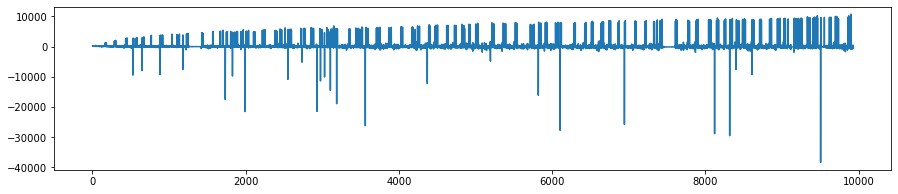

In [28]:
plt.subplots(figsize=(15,3))
plt.plot(range(len(learned_values['diff'])), learned_values['diff'])
plt.show()

Above is the `diff` value at each step of the learning process. We can see that it spikes up regularly to around 10000, and in fact the spikes get taller as the learning goes on. (Presumably, these spikes are relatively rare compared toother important factors that go into `diff`, since the algorithm is suppossed to minimize `diff`...)

Actually,these spikes are entirely explained by the `hunger_ttl` feature: they happen when the goose eats a food item (and there was still a chance of it starving before the end of the game). This increases the `hunger_ttl` parameter by 40  - the goose will now survive 40 more turns. And since the learning considers `hunger_ttl` important, it keeps increasing its magnitude, thus also increasing the spikes.

Below are the graphs for most of the weights of the Q functions. Usually, after 10000 steps, the weights are clearly not ready to converge yet. This lets me know to train for longer than 10000 steps (which I did in my actual experiments).

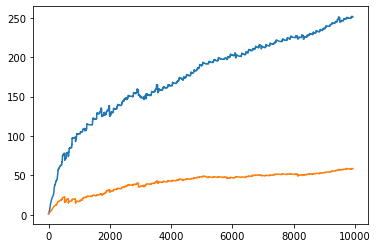

In [29]:
plt.plot(range(len(learned_values['hunger_ttl'])), learned_values['hunger_ttl'])
plt.plot(range(len(learned_values['uncontested_space'])), learned_values['uncontested_space'])

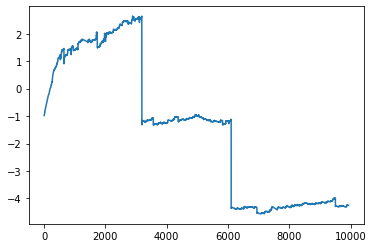

In [30]:
plt.plot(range(len(learned_values['nearest_food_dist'])), learned_values['nearest_food_dist'])


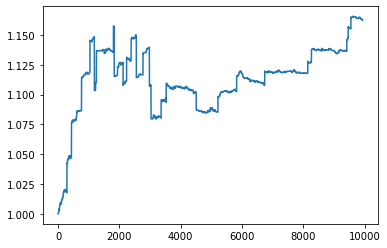

In [31]:
plt.plot(range(len(learned_values['delta_length'])), learned_values['delta_length'])

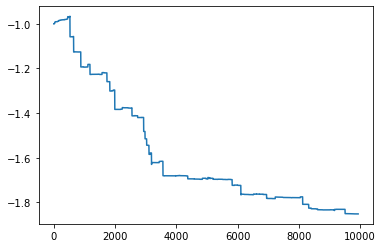

In [32]:
plt.plot(range(len(learned_values['chance_to_collide'])), learned_values['chance_to_collide'])


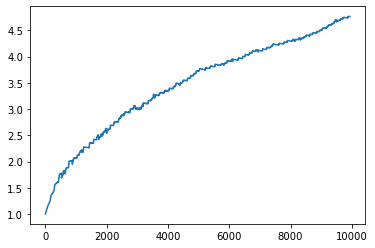

In [33]:
plt.plot(range(len(learned_values['one'])), learned_values['one'])


Finally, below is a rolling average of how well the goose is actually doing in the game: the average place it took over the last 50 training games. This lets  me verify that the goose is actually learning to find winning moves, and not to make self-fulfilling suicidal prophecies...

<AxesSubplot:>

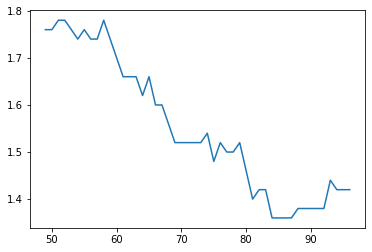

In [34]:
import pandas as pd
pd.Series(place_record).rolling(50).mean().plot()

# Future work

There are lots of ways to improve on this baseline, some of which I will probably do:

- Debug and improve the Q-functions: the `uncontested_space` one definitely needs fixing; and I have a general idea in mind for how I want to recombine them, e.g. zero-out all or most reward functions for actions that I *know* will kill the goose. I'm sure there are also other new important features I'll think of along the way.
- Optimize for winning: the learning part of Q-learning is currently optimizing for *score*, but I don't care about score. Q-learning is supposed to be good at learning about delayed rewards, so I may be able to optimize for *placement* directly? 
    - To do this effectively, I'll also need to track features about how well the *other* geese are doing, compared to me.
- Do offline and/or off-policy learning: I can learn from the logs of other agents playing the game, and even my agents playing against real opponents. And if I'm not doing online learning, I can posssibly even find a more stable algorithm to find the best Q-value approximation, e.g. just linear regression?..
    - While I'm doing linear regression, I might be able to verify whether the relationship between my features and the Q-value is even linear! For example, it might be worthwhile to take the log of some of the ttl and/or space-based features: having *lots* of space and having (*lots* of space + 5) should make less of a difference than having zero space vs. 5 squares' worth of space.
- Try some of the stability/optimization tricks in the [wikipedia article](https://en.wikipedia.org/wiki/Q-learning). One thing that stands out to me is: "The advantage of Greedy GQ is that convergence is guaranteed even when function approximation is used to estimate the action values." Guaranteed convergence would be nice!